# Project on Heart Disease (Group 73)

## Introduction

Heart disease is a broad term that refers to different heart conditions. Something in common is their effect on blood flow and dilation of veins to the heart. Other factors such as age, cholestrol, and blood pressure are also closely linked with heart disease.  
Our aims is whether these factors have a correlation with heart disease, and provide a classification model predicting whether a person has heart disease based on four factors:
1. Age [age]
2. Resting blood pressure (in mm Hg on admission to the hospital) [trestbps]
3. Cholesterol [chol]
4. Maximum heart rate achieved [thalach]

The data was taken from the UCI Machine Learning Repository's Heart Disease Dataset to train our model to predict whether someone has heart disease based on the 4 risk factors listed above. Our model will diagnoses heart disease based on the percentage of narrowing in major arteries (<50% meaning no heart disease and >50% meaning heart disease). 

The direcotry is retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. There are four databases: Cleveland, Hungary, Long Beach (California), and Switzerland. The Hungarian data was chossen due to its binary column indicating whether a person is likely to have heart disease. The dataset was collected from the Hungarian Institute of Cardiology in Budapest.

## Data Preparation

Attach libraries.

In [1]:
# Attatch the libraries
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Load the hungarian heart disease dataset and set proper column names.

In [2]:
# load hungarian heart disease dataset from database

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"

hungarian_data <- read_csv(url, col_names = c('age', 'sex', 'chest_pain', 'resting_blood_pressure', 'cholesterol', 
                                              'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina',
                                              'st_depression', 'peak_st_slope', 'major_vessel_num', 'thal', 'diagnosis'))
head(hungarian_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_e...
dbl (5): age, sex, chest_pain, st_depression, diagnosis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,peak_st_slope,major_vessel_num,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


Clean the dataset and select the columns we need for our model.

In [3]:
hungarian_clean <- hungarian_data |>
    # Select applicable columns to use as predictors.
    select(age, resting_blood_pressure, cholesterol, max_heart_rate, diagnosis) |>
    # Change the diagnosis column to factor so that it can be used as the predicted result.
    mutate(diagnosis = as.factor(diagnosis))

# Mutate the data frame so that all of the numerical predictors are doubles rather than characters.             
as_double <- c("resting_blood_pressure", "cholesterol", "max_heart_rate")
hungarian_clean[as_double] <- lapply(hungarian_clean[as_double], as.double)

#Get rid of any rows with NA
hungarian_clean <- hungarian_clean |>
            filter_all(all_vars(!is.na(.)))

# View the cleaned dataframe.
glimpse(hungarian_clean)

Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”
Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”
Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”


Rows: 270
Columns: 5
$ age                    <dbl> 28, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35,…
$ resting_blood_pressure <dbl> 130, 120, 170, 100, 105, 110, 125, 120, 130, 15…
$ cholesterol            <dbl> 132, 243, 237, 219, 198, 225, 254, 298, 161, 21…
$ max_heart_rate         <dbl> 185, 160, 170, 150, 165, 184, 155, 185, 190, 16…
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


Split the cleaned data into training set and testing set (75% for training and 25% for testing). This proportion was chosen so that there is sufficient training data and testing data and a common convention (Dr. Campbell). 

In [4]:
# Split data into training set and testing set.
set.seed(1000)

hungarian_split <- initial_split(hungarian_clean, prop = 0.75, strata = diagnosis)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

Creating an exploratory data analysis table using the training dataset.

In [5]:
hungarian_training_explore <- hungarian_train |>
            group_by(diagnosis)|>
            summarize(n_row = n(),
                      percentage_of_total_data = n()*100/nrow(hungarian_train),
                      age_mean = mean(age),
                      resting_blood_pressure_mean = mean(resting_blood_pressure),
                      cholesterol_mean = mean(cholesterol),
                      max_heart_rate_mean = mean(max_heart_rate))

hungarian_training_explore

diagnosis,n_row,percentage_of_total_data,age_mean,resting_blood_pressure_mean,cholesterol_mean,max_heart_rate_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,126,62.68657,46.77778,129.7619,238.4921,144.6270
1,75,37.31343,49.36000,134.7600,274.4667,129.1867


Visualizing distribution of predictor variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



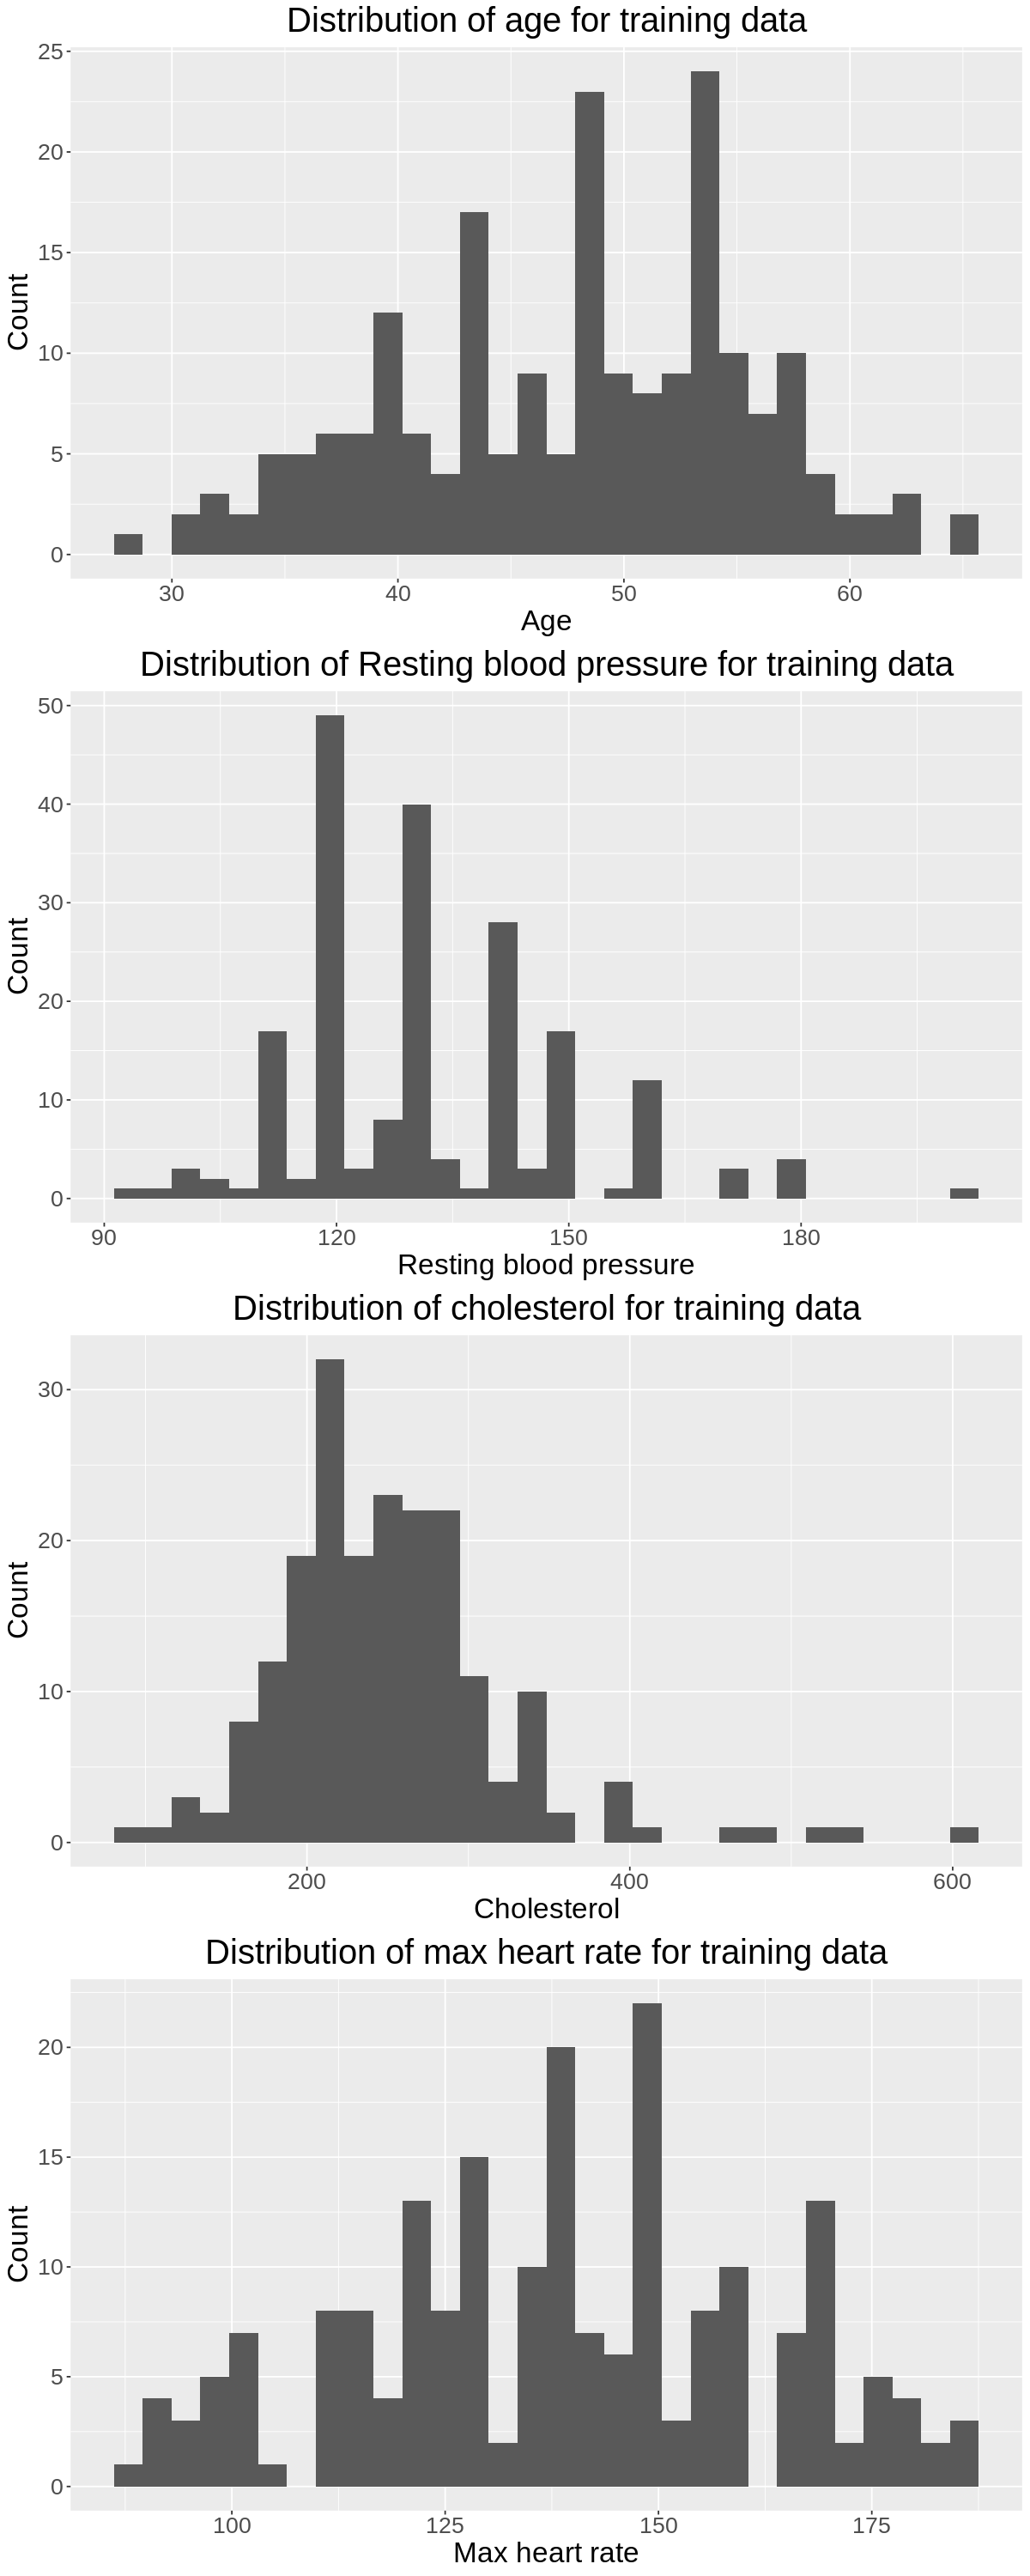

In [6]:
options(repr.plot.width = 10, repr.plot.height = 25)
plot_column <- c('age','resting_blood_pressure', 'cholesterol', 'max_heart_rate')

training_age_plot <- hungarian_train |>
                ggplot(aes(x=age))+
                geom_histogram()+
                labs(x="Age", y="Count")+
                ggtitle("Distribution of age for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_resting_blood_pressure_plot <- hungarian_train |>
                ggplot(aes(x=resting_blood_pressure))+
                geom_histogram()+
                labs(x="Resting blood pressure", y="Count")+
                ggtitle("Distribution of Resting blood pressure for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_cholesterol_plot <- hungarian_train |>
                ggplot(aes(x=cholesterol))+
                geom_histogram()+
                labs(x="Cholesterol", y="Count")+
                ggtitle("Distribution of cholesterol for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_max_heart_rate_plot <- hungarian_train |>
                ggplot(aes(x=max_heart_rate))+
                geom_histogram()+
                labs(x="Max heart rate", y="Count")+
                ggtitle("Distribution of max heart rate for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

hungarian_training_plot <- plot_grid(training_age_plot,
                                     training_resting_blood_pressure_plot, 
                                     training_cholesterol_plot, 
                                     training_max_heart_rate_plot,
                                     ncol=1)

hungarian_training_plot

In [7]:
The graphs show a normal distribution of the varibles. 

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: The graphs
        ^


## Method

We will build the classification model using k-nearest neighbors, the training data (hungarian_train) and test it for accuracy using the testing data (hungarian_test). With cross-validation k number will be chosen, using tune for highest accuracy. The predictor variables will have a numerical data type (not factorable data type), as distance cannot be calculated for factors in k-nearest neighbors.

Then we visualize the tuning using cross-validation, by plotting a graph with number of k vs accuracy. 

## Expected Outcomes and Significance

We expect to find a correlation between our four risk factors and likelyhood of having heart disease. Our goal of creating a model with high accuracy of heart disease prediction, if sucessful, can aid the medical community by creating a fast and easier diagnosis of heart disease, such as in a rural setting where equiment like ECG may not exist. They could input our measurements for each of our 4 risk factors that need minimal equipment and determine whether the patient is developing heart disease. 

Future questions:
- Is our model applicable to other regions such as longbeach?
- Is it ethical to rely only on a model and remove a doctors role?
- Can a model be 100% accurate?
- Could these data points be used aginst individuals by insurance companies as a form of stigmitization? How do we protect data but publisize it for others?